# Demo for gammon NLP project

In this demo, we are going to walk through the detail of how to apply cutting-edge nlp model of transformer techs to solve the challenging commercial problem. We will seperate it into 2 sections. One is a analysis of our project result on evalutaion dataset and one is a demonstration how to deploy the well fine-tuned model into a product service. As we have already well trained the model, this repo will only demotrate the post training part. 

## Analysis of a cutting-edge nlp model for safety issues classifcation

First, we will import the libraries that we are going to used for this demo. They will include cutting edge transformers lib of huggingface, sklearn for metric analysis and pandas related libs for data processing.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import math
from tqdm import tqdm

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

In [3]:
import torch
from torchmetrics import PrecisionRecallCurve
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast, TextClassificationPipeline

Next, we are going to implement some important and useful util functiosn for preprocessing, postprocessing and model performance analysis. 

In [4]:
def get_label_list(label_list_path):
    label_list_file = open(label_list_path, 'r')
    label_list = []
    for line in label_list_file.readlines():
        label_list.append(line.replace('\n', '').lower())

    return label_list

def preprocess(batch_data_df):
    batch_corpus = []
    batch_target = []
    for row_id in range(len(batch_data_df)):
        row = batch_data_df.iloc[row_id]
        actions_text = row['Immediate Actions Taken'][:-1].replace('\n', '') if row['Immediate Actions Taken'][-1] == '.' else row['Immediate Actions Taken'].replace('\n', '')
        description_text = row['Short Event Description'][:-1].replace('\n', '') if row['Short Event Description'][-1] == '.' else row['Short Event Description'].replace('\n', '')
        category = ' '.join([word.lower() for word in row['Classification'].split(' ') if word != ''])
        if row['Short Event Description'] != "UNKNOWN" and row['Immediate Actions Taken'] != "UNKNOWN":
            corpus = "Short event description: " + description_text + "; " + 'Immediate Actions Taken: ' + actions_text + '.'
        elif row['Short Event Description'] == "UNKNOWN" and row['Immediate Actions Taken'] != "UNKNOWN":
            corpus = 'Immediate Actions Taken: ' + actions_text + '.'
        elif row['Short Event Description'] != "UNKNOWN" and row['Immediate Actions Taken'] == "UNKNOWN":
            corpus = "Short event description: " + description_text + '.'
        else:
            raise ValueError('text to corpus transform failed')

        batch_corpus.append(corpus.lower())
        batch_target.append(category.lower())
    
    return batch_corpus, batch_target

def postprocess(batch_output):
    prediction = []
    confidence_score = []
    for output in batch_output:
        prediction.append(label_list[int(output['label'].split('_')[1])])
        confidence_score.append(output['score'])
    
    return prediction, confidence_score

def postprocess_all_classes(batch_output_all_classes):
    confidence_score_tensor_list = []
    for output in batch_output_all_classes:
        confidence_score_list = []
        for label_dict in output:
            confidence_score_list.append(label_dict['score'])
        confidence_score_tensor_list.append(confidence_score_list)
    
    return torch.tensor(confidence_score_tensor_list, dtype=torch.float32)

def make_confusion_matrix(all_prediction, all_target, normalize='true'):
    y_pred = [label_list.index(pred) for pred in all_prediction]
    y_true = [label_list.index(target) for target in all_target]
    
    categories = [label_list[index] for index in sorted(set(list(set(y_pred)) + list(set(y_true))))]
    cf_matrix = confusion_matrix(y_true, y_pred, normalize=normalize)
    df_cm = pd.DataFrame(cf_matrix, index = [i for i in categories], columns = [i for i in categories])
    
    plt.figure(figsize = (15,8))

    if normalize == 'true':
        plt.title('Confusion matrix with diagonal entries as recall')
        sn.heatmap(df_cm, annot=True, vmin=0, vmax=1)
    elif normalize == 'pred':
        plt.title('Confusion matrix with diagonal entries as precision')
        sn.heatmap(df_cm, annot=True, vmin=0, vmax=1)
    
def get_accuracy(all_prediction, all_target):
    y_pred = np.array([label_list.index(pred) for pred in all_prediction])
    y_true = np.array([label_list.index(target) for target in all_target])
    correct_pred = (y_pred == y_true)
    accuracy = correct_pred.sum() / y_true.shape[0]
    
    return accuracy

def make_pr_curve(all_confidence_score_tensor, all_target):
    y_true = np.array([label_list.index(target) for target in all_target])
    y_true_binarized = label_binarize(y_true, classes=[i for i in range(len(label_list))])
    
    average_precision_all_classes = average_precision_score(y_true_binarized, all_confidence_score_tensor.cpu().detach().numpy(), average="micro")
    precision, recall, _ = precision_recall_curve(y_true_binarized.ravel(), all_confidence_score_tensor.ravel())
    
    plt.figure(figsize = (15,8))
    plt.title('PR curve over all classes with average precision :{}'.format(round(average_precision_all_classes, 3)))
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    sn.lineplot(recall, precision, drawstyle='steps-pre')


In [5]:
checkpoint_path = './checkpoint/checkpoint-18000'
label_list = get_label_list('./data/label_list.txt')
eval_data_df = pd.read_excel("./data/evaluation_data.xlsx").fillna('UNKNOWN')

This time, our case is to predict a sequence class for each corpus input. The model that we pick is a distilbert attched with 2 more additional ffn layers for classification. The model has already fine-tuned on our train set. We will load the fine-tuned model, tokenizer and a pipline instance to embedd them together.

In [6]:
model = DistilBertForSequenceClassification.from_pretrained(checkpoint_path)
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased-distilled-squad")
pipline = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=1)
pipline_all_classes = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=1, return_all_scores=True)

In [7]:
batch_size = 32
slice_start_indices = list(range(len(eval_data_df)))[::batch_size]
slice_end_indices = list(range(len(eval_data_df)))[::batch_size][1:] + [None]

In [8]:
all_prediction = []
all_confidence_score = []
all_target = []
all_confidence_score_tensor_list = []
for start_index, end_index in tqdm(zip(slice_start_indices, slice_end_indices)):
    if end_index != None:
        batch_data_df = eval_data_df[start_index:end_index]
    else:
        batch_data_df = eval_data_df[start_index:]
        
    batch_corpus, batch_target = preprocess(batch_data_df)
    output = pipline(batch_corpus)
    batch_prediction, batch_confidence_score = postprocess(output)
    
    all_prediction += batch_prediction
    all_confidence_score += batch_confidence_score
    all_target += batch_target
    
    output_all_classes = pipline_all_classes(batch_corpus)
    confidence_score_tensor = postprocess_all_classes(output_all_classes)
    all_confidence_score_tensor_list.append(confidence_score_tensor)
    
all_confidence_score_tensor = torch.cat(all_confidence_score_tensor_list, dim=0)


12it [00:01, 11.08it/s]


In [9]:
accuracy = get_accuracy(all_prediction, all_target)
print('Accuracy :', accuracy)

Accuracy : 0.8054054054054054


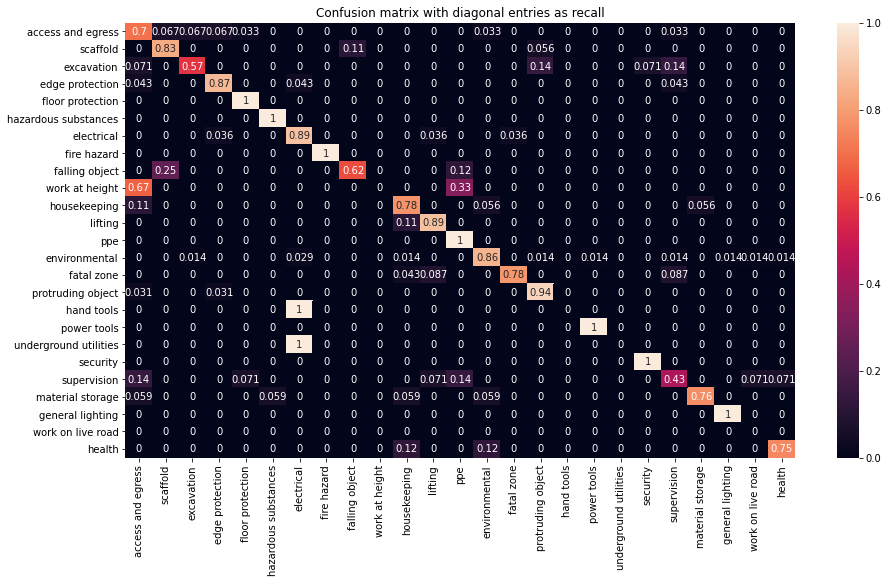

In [10]:
make_confusion_matrix(all_prediction, all_target, normalize='true')

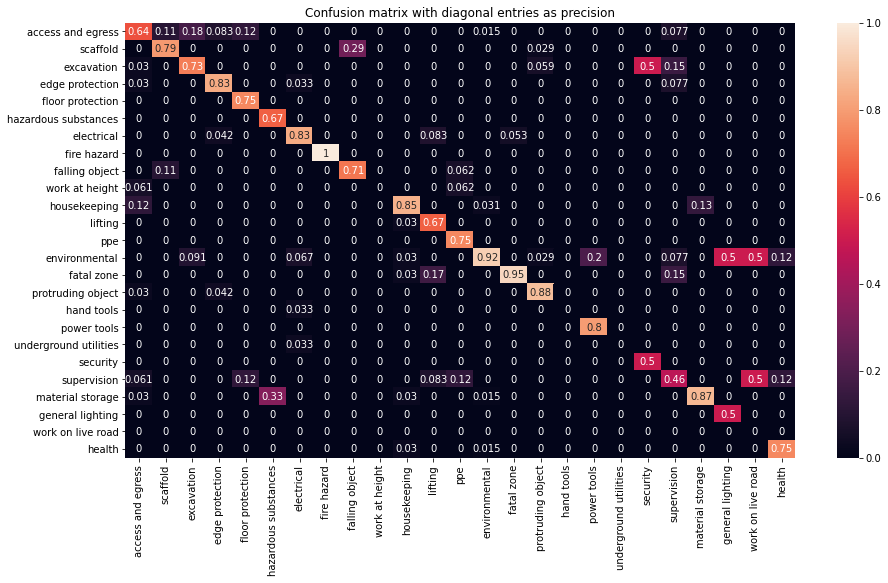

In [11]:
make_confusion_matrix(all_prediction, all_target, normalize='pred')

/home/gammon/miniconda3/envs/tc/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


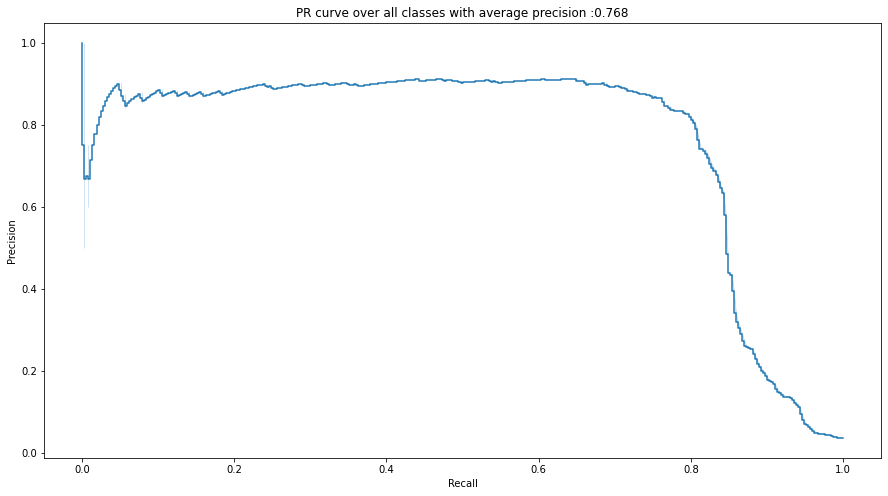

In [12]:
make_pr_curve(all_confidence_score_tensor, all_target)

Next, we will demonstrate some specific cases which are hard samples as their content contain similar wordings.

In [13]:
corpus_1 = "short event description: Found rusty toe planks on the scaffold platform. There is cap between planks. Causes of falling objects. South plot-T42, Area 5; Action Taken: Replaced the good planks and covered the floor opening."
ground_true_1 = 'falling object	'
output_1 = pipline(corpus_1)
prediction_1, confidence_score_1 = postprocess(output_1)

corpus_2 = "short event description: S77; Action Taken: Scaffolding platform not put hand rail and put safe tag" 
ground_true_2 = 'scaffold'
output_2 = pipline(corpus_2)
prediction_2, confidence_score_2 = postprocess(output_2)

print('corpus: ', corpus_1)
print('ground true: ', ground_true_1)
print('prediction: ', prediction_1[0])
print('confidence score: ', confidence_score_1[0])
print('-----------------------------------------------------------------------------------------------------')
print('corpus: ', corpus_2)
print('ground true: ', ground_true_2)
print('prediction: ', prediction_2[0])
print('confidence score: ', confidence_score_1[0])

corpus:  short event description: Found rusty toe planks on the scaffold platform. There is cap between planks. Causes of falling objects. South plot-T42, Area 5; Action Taken: Replaced the good planks and covered the floor opening.
ground true:  falling object	
prediction:  falling object
confidence score:  0.911653459072113
-----------------------------------------------------------------------------------------------------
corpus:  short event description: S77; Action Taken: Scaffolding platform not put hand rail and put safe tag
ground true:  scaffold
prediction:  scaffold
confidence score:  0.911653459072113


The above we have demostrated the perfromance of the distilbert based sequence classification model which is only be trained on about 1000 training samples. Comparing to the number of the classes that it needs to do, the train data size is relative small but it's performance is already being robust.

The specific cases of "falling object" and "scaffold" demonstrated that the pretrained distilbert LM has gained a very strong NLU ability and do a good sequence classification task by well understanding the semantic meaning of each corpus. Both of the sentences contain scaffold and some similar key words but they have different semantic meanings. one is descripting the issues is related to scaffold but the root problem is the worry of falling object while the other one is putting the safety concern on the condition of scaffold itself. This is even hard to non-expert human to classify but the model classifiy it perfectly. The performance is stuning. 

By accessing to the accuracy, confusion matrix, PR-curve and the average precision, we can see that our sequence classification model is robust. But there is still some shorcomming can be imporved. Taking a look to the average precision and the PR-curve. the data size of some of the categories is relative small. That means the dataset is a bit unbalanced. So, applying resampling algorithm or collect more data from minority categories can further help to improve the model.  

## Create a inference service with ray

In this section, I will demonstrate how to implement a light weight inference server with ray.serve to deploy model for small scale inference servics.

In [14]:
import ray
from ray import serve

import requests
import json

The inference server will handle all the input json and preprocessed them into desired plain text input format for inference. Then will wrap up all the output and postprocessed into the output json format.

In [15]:
class LightWeightSequenceClassificationInferenceServer():
    def __init__(self, checkpoint_path):
        model = DistilBertForSequenceClassification.from_pretrained(checkpoint_path)
        tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased-distilled-squad")
        self.infer_manager =  TextClassificationPipeline(model=model, tokenizer=tokenizer, device=0)

    def verify_request_json_required_structure(self, request_input):
        if 'input_item' not in request_input.keys():
            return False
        else:
            for item in request_input['input_item']:
                if 'short_event_description' not in item.keys():
                    return False
                elif 'action_taken' not in item.keys():
                    return False
                elif 'issue_id' not in item.keys():
                    return False

        return True
    
    def preprocess(self, request_input):
        preprocessed_input = {'issue_id':[], 'corpus':[]}
        for item in request_input['input_item']:
            preprocessed_input['issue_id'].append(item['issue_id'])
            actions_text = item['action_taken'][:-1].replace('\n', '') if item['action_taken'][-1] == '.' else item['action_taken'].replace('\n', '')
            description_text = item['short_event_description'][:-1].replace('\n', '') if item['short_event_description'][-1] == '.' else item['short_event_description'].replace('\n', '')
            if item['short_event_description'] != "UNKNOWN" and item['action_taken'] != "UNKNOWN":
                corpus = "Short event description: " + description_text + "; " + 'Immediate Action Taken: ' + actions_text + '.'
            elif item['short_event_description'] == "UNKNOWN" and item['action_taken'] != "UNKNOWN":
                corpus = 'Immediate Action Taken: ' + actions_text + '.'
            elif item['short_event_description'] != "UNKNOWN" and item['action_taken'] == "UNKNOWN":
                corpus = "Short event description: " + description_text + '.'
            else:
                raise ValueError('text to corpus transform failed')

            preprocessed_input['corpus'].append(corpus.lower())

        return preprocessed_input
    
    def postprocess(self, batch_inference_output, issue_id):
        output_to_response = []
        for inference_output, issue_id in zip(batch_inference_output, issue_id):
            prediction = label_list[int(inference_output['label'].split('_')[1])]
            confidence_score = inference_output['score']
            output = {'issue_id':issue_id, 'prediction':prediction, 'confidence_score':confidence_score}
            output_to_response.append(output)

        return output_to_response
    
    def infer(self, request_input):
        preprocessed_input = self.preprocess(request_input)
        batch_corpus = preprocessed_input['corpus']
        batch_output = self.infer_manager(batch_corpus)
        output_to_response = self.postprocess(batch_output, preprocessed_input['issue_id'])
        
        return output_to_response
        
    async def __call__(self, request_from_user):
        request_input = await request_from_user.json()
        if self.verify_request_json_required_structure(request_input):
            output_to_response = self.infer(request_input)
            print(output_to_response)
            return {'output_item':output_to_response, 'model_version': 'v1.0', 'message':'succeed'}
        else:
            return {'output_item':[], 'model_version': 'v1.0', 'message':'missing required key in input json'}

Deploy the inference server with ray, only takes a few lines. We can allocate suitable cpu and gpu resources we want. The rest of the backend messy will handle by ray. Before we deploy the server, we will need to init the ray instance first by input "ray start --head" in the terminal.

In [16]:
checkpoint = '/home/gammon/Jay/gammon_nlp_project_demo/checkpoint/checkpoint-18000'
ray.init(address='auto', _redis_password='5241590000000000')
serve.start(detached=True, http_host='0.0.0.0', http_port=8000)
serve.create_backend('safety_issue_classification:v1.0',
                     LightWeightSequenceClassificationInferenceServer,
                     checkpoint,
                     ray_actor_options={'num_cpus':4, 'num_gpus':1})
serve.create_endpoint("safety_issue_classifier",
                      backend="safety_issue_classification:v1.0",
                      route="/classify_safety_issue",
                      methods=['POST'])

print('successfully init inference server')

2021-06-13 22:45:44,202	INFO worker.py:641 -- Connecting to existing Ray cluster at address: 10.1.3.227:6379
(pid=31538) 2021-06-13 22:45:44,771	INFO http_state.py:70 -- Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:SERVE_PROXY_ACTOR-node:10.1.3.227-0' on node 'node:10.1.3.227-0' listening on '0.0.0.0:8000'
(pid=31563) INFO:     Started server process [31563]
(pid=31538) 2021-06-13 22:46:00,043	INFO controller.py:179 -- Registering route '/classify_safety_issue' to endpoint 'safety_issue_classifier' with methods '['POST']'.


successfully init inference server


Next, we write a simple test function to test whehter the inference end point work properly.

In [17]:
def test_client():
    print('----------------------test client----------------------------')
    pay_load = {
        'input_item':[
            {
                'issue_id':'A0125',
                'short_event_description':'Found rusty toe planks on the scaffold platform. There is cap between planks. Causes of falling objects. South plot-T42, Area 5',
                'action_taken': 'Replaced the good planks and covered the floor opening.'
            },
            {
                'issue_id':'A0123',
                'short_event_description':'S77',
                'action_taken': 'Action Taken: Scaffolding platform not put hand rail and put safe tag'
            }
        ],
    }
    resp = requests.post("http://10.1.3.227:8000/classify_safety_issue", data=json.dumps(pay_load))
    print(resp.text)
    

In [18]:
test_client()

----------------------test client----------------------------
{
  "output_item": [
    {
      "issue_id": "A0125",
      "prediction": "falling object",
      "confidence_score": 0.9116370677947998
    },
    {
      "issue_id": "A0123",
      "prediction": "scaffold",
      "confidence_score": 0.9080348014831543
    }
  ],
  "model_version": "v1.0",
  "message": "succeed"
}
(pid=31617) [{'issue_id': 'A0125', 'prediction': 'falling object', 'confidence_score': 0.9116370677947998}, {'issue_id': 'A0123', 'prediction': 'scaffold', 'confidence_score': 0.9080348014831543}]


Everything seems great. Now, we can use our state of the art safety issues classification services to automatic classify the safety issues smartly. 